# Detect spots (modified for IPQDA)

In [1]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


#### (IPQDA: Change values here)

In [2]:
# hard-code the paths of our input and output directories

path_input = "big-fish-IPQDA/data/input/JQ1"

path_output = "big-fish-IPQDA/data/output/JQ1"


In this notebook, we show examples of **mRNAs detection**. We use 3D images. Three main steps are developed:
- Spot detection - Detection of spots as local maximum.
- Dense region decomposition - Decomposition of dense and bright regions by simulating as many new spots in these regions as possible.
- Clusters detection - Detection of clustered spots.

#### (IPQDA: Change values here)

In [3]:
#Change filename
path = os.path.join(path_input, "JQ1_317_smfish_fov_1.tif")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

smfish channel
 shape: (15, 512, 512)
 dtype: uint16


In [4]:
rna_mip = stack.maximum_projection(rna)
print("smfish channel (2D maximum projection)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))

smfish channel (2D maximum projection)
 shape: (512, 512)
 dtype: uint16


## Spot detection

We assume **spot is a local maximum** in the smFISH channel. Three steps are required to detect them:
- Filter the smFISH channel to enhance the signal-to-noise ratio and denoise the image (`bigfish.stack.log_filter`).
- Detect the local maximum in the filtered image (`bigfish.detection.local_maximum_detection`).
- Remove the local maximum under a fixed threshold (`bigfish.detection.spots_thresholding`). To be robust, the thresholding should be applied on the filtered image. Thus, the threshold is set relatively to the filtered image values.
- If necessary, the optimal threshold can be estimated with `bigfish.detection.automated_threshold_setting` (applied on a filtered image).

All these steps are summarized in `bigfish.detection.detect_spots` that return the 2D or 3D coordinates of the detected spots.

In [5]:
spots, threshold = detection.detect_spots(
    images=rna, 
    return_threshold=True, 
    voxel_size=(300, 103, 103),  # in nanometer (one value per dimension zyx)
    spot_radius=(350, 150, 150))  # in nanometer (one value per dimension zyx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (57, 3)
 dtype: int64
 threshold: 87.0


Given the **voxel size** and the expected **spot radius** (in nanometer), the function `bigfish.detection.detect_spots` automatically estimates a **kernel size** for the LoG filtering and a **minimal distance** between two spots we want to be able to detect separately. It is still possible to set these parameters explicitly in order to fine-tune the detection. Internally, we approximate them as the spot radius in pixel with the function `bigfish.detection.get_object_radius_pixel`.

In [6]:
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(300, 103, 103), 
    object_radius_nm=(350, 150, 150), 
    ndim=3)
print("spot radius (z axis): {:0.3f} pixels".format(spot_radius_px[0]))
print("spot radius (yx plan): {:0.3f} pixels".format(spot_radius_px[-1]))

spot radius (z axis): 1.167 pixels
spot radius (yx plan): 1.456 pixels


In [7]:
spots, threshold = detection.detect_spots(
    images=rna, 
    return_threshold=True, 
    log_kernel_size=(1.167, 1.456, 1.456),
    minimum_distance=(1.167, 1.456, 1.456))
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (57, 3)
 dtype: int64
 threshold: 87.0


__Note:__ What we call spot radius in this notebook can be understood as its **Point Spread Function (PSF)**. For simplicity sake, this PSF is modelled as a 2D or 3D gaussian.

#### (IPQDA: Figure 1 - Spot detection)

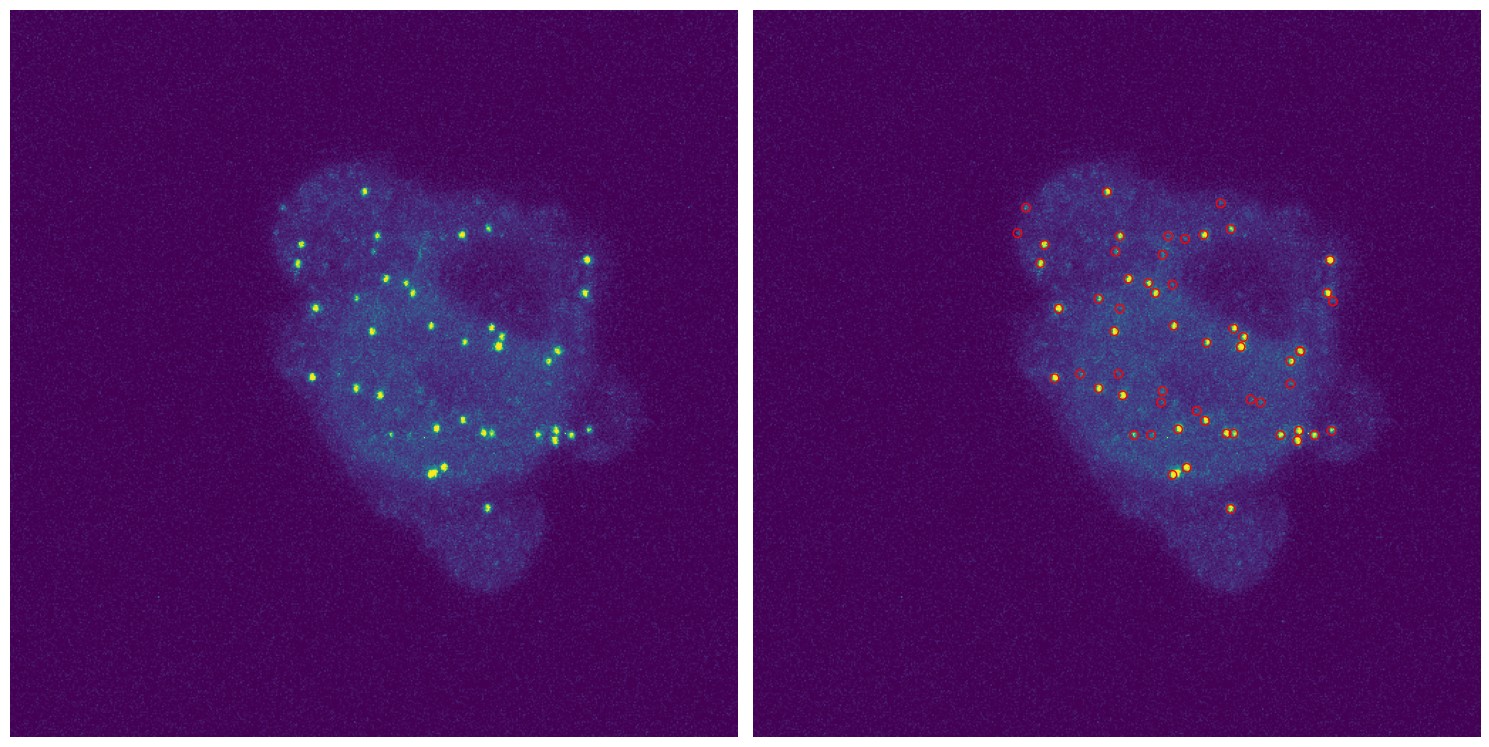

In [8]:
plot.plot_detection(rna_mip, spots, contrast=True)

The automated spot detection method tries to find the optimal threshold to discriminate actual spots from noisy blobs. If we plot the number of the spots detected as a function of threshold level we observe an **elbow curve**. The selected threhold is the one located in the breaking point of the curve. This curve can be plotted with `bigfish.plot.plot_elbow`.

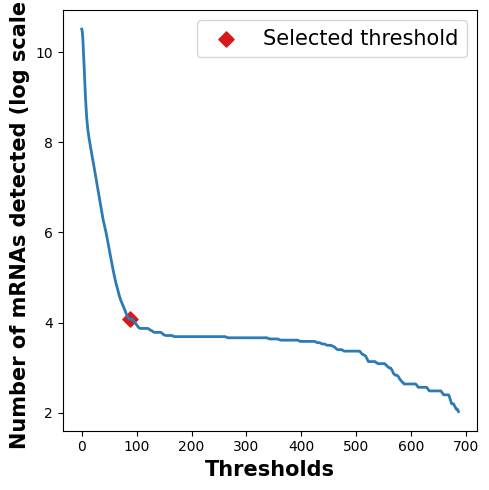

In [9]:
plot.plot_elbow(
    images=rna, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150))

## Dense region decomposition

The detection of local maximum is not able to detect individual spots clustered in a dense and bright region. We try to **decompose these regions by simulating as many spots as possible until we match the original region intensity**. Our current steps are:
- Denoise the smFISH channel by estimating then removing its background (`bigfish.stack.remove_background_gaussian`).
- Build a reference median spot from the individual predetected spots (`bigfish.detection.build_reference_spot`).
- Fit a gaussian signal on the reference spot (`bigfish.detection.modelize_spot`).
- Detect the candidate dense regions in the denoised image - large regions brighter than the reference spot (`bigfish.detection.get_dense_region`).
- Use the fitted gaussian signal to fill as many spots in the candidate regions as possible (`bigfish.detection.simulate_gaussian_mixture`).

All these steps are summarized in `bigfish.detection.decompose_dense` that return the 2D or 3D coordinates of the detected spots outside and inside a decomposed region, additional information about the regions themself and an image of the reference spot estimated.

In [10]:
spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
    image=rna, 
    spots=spots, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150), 
    alpha=0.7,  # alpha impacts the number of spots per candidate region
    beta=1,  # beta impacts the number of candidate regions to decompose
    gamma=5)  # gamma the filtering step to denoise the image
print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (57, 3)
 dtype: int64 

detected spots after decomposition
 shape: (69, 3)
 dtype: int64


#### (IPQDA: Figure 2 - Spot detection after decomposing the regions)

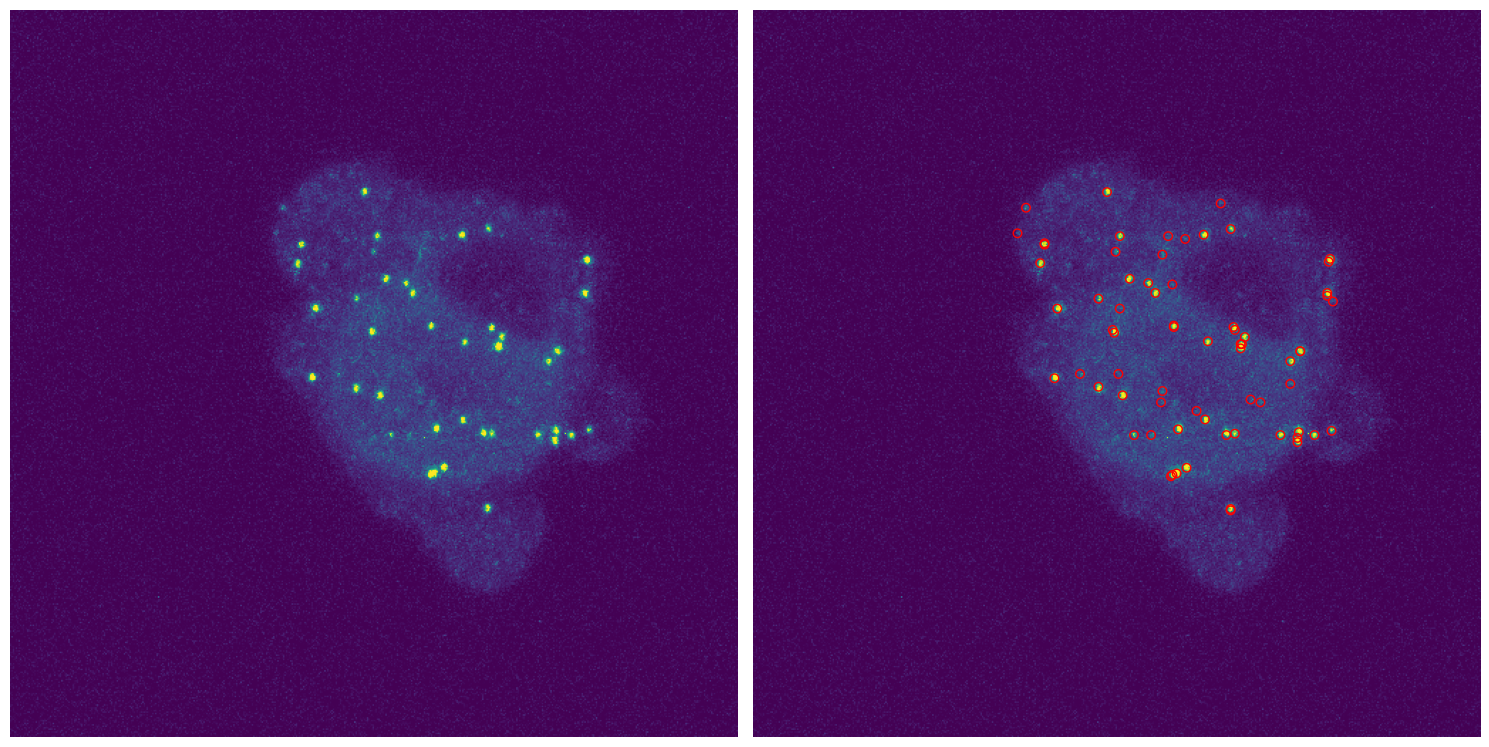

In [11]:
plot.plot_detection(rna_mip, spots_post_decomposition, contrast=True)

## Clusters detection

Two spots are considered connected if they localized within a specific radius (in nanometer). Above a minimum number of connected spots, a cluster can be defined. This detection can be computed with `bigfish.detection.detect_clusters`.

In [12]:
spots_post_clustering, clusters = detection.detect_clusters(
    spots=spots_post_decomposition, 
    voxel_size=(300, 103, 103), 
    radius=350, 
    nb_min_spots=2)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))

detected spots after clustering
 shape: (69, 4)
 dtype: int64 

detected clusters
 shape: (9, 5)
 dtype: int64


#### (IPQDA: Figure 3 - Cluster detection)

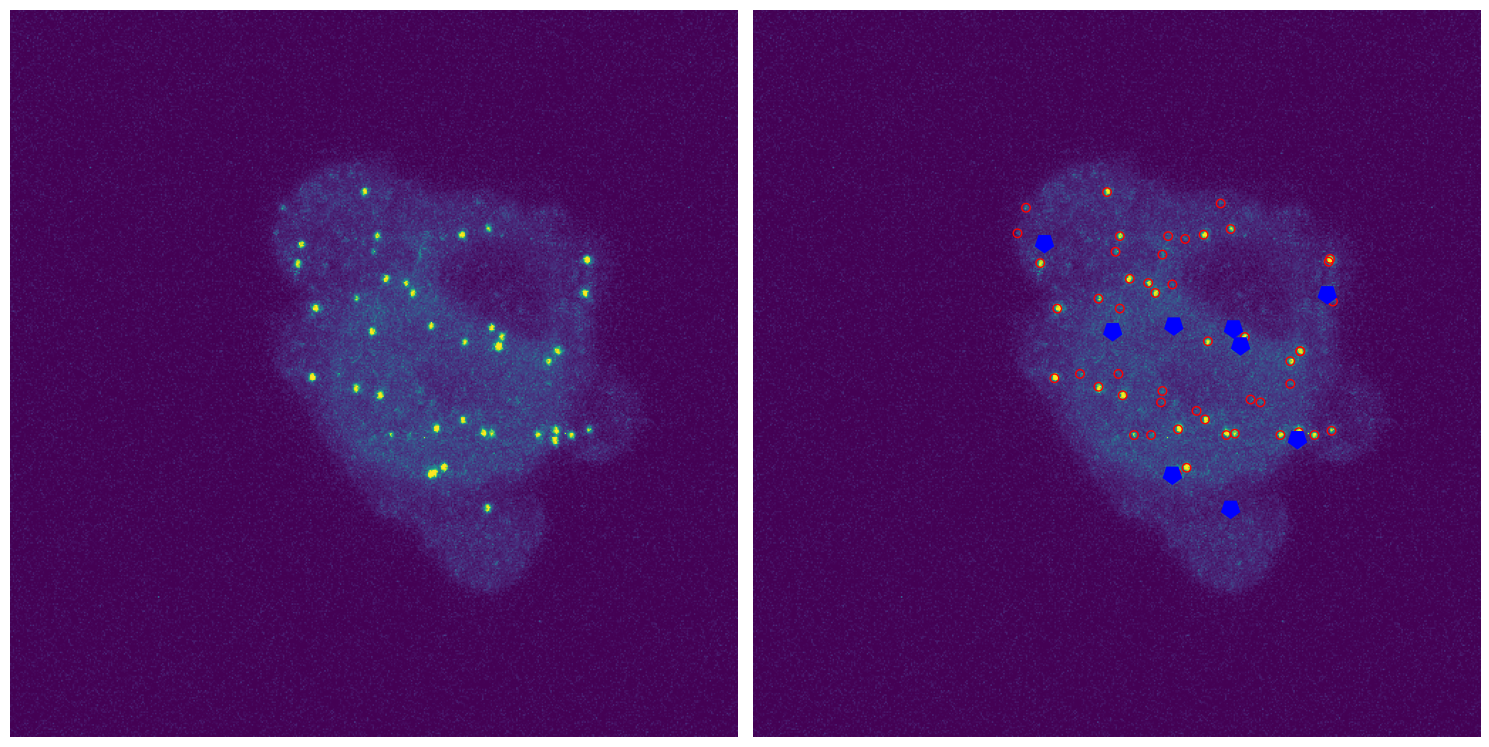

In [13]:
# plot
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, clusters[:, :3]], 
                    shape=["circle", "polygon"], 
                    radius=[3, 6], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    contrast=True)

## Save results

Spots and foci coordinates can be saved in **npy files** (numpy dedicated format) or **csv files** using functions `bigfish.stack.save_array` and `bigfish.stack.save_data_to_csv` respectively.

#### (IPQDA: Change values here)

In [14]:
# save in csv files
path_spots = os.path.join(path_output, "JQ1_317_spots.csv")
stack.save_data_to_csv(spots_post_clustering, path_spots)

path_clusters = os.path.join(path_output, "JQ1_317_clusters.csv")
stack.save_data_to_csv(clusters, path_clusters)